### Exponential Smoothing and SARIMA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [2]:
sales = pd.read_csv('dataset/sales_dataset.csv', parse_dates=True, index_col=0)

In [3]:
sales.to_period().head()

,Sales
Month,
1984-01,2815
1984-02,2672
1984-03,2755
1984-04,2721
1984-05,2946


In [4]:
len(sales)

105

In [5]:
any(sales.index.isnull())

False

In [6]:
any(sales.Sales.isnull())

False

There are no missing values in the data.

In [7]:
sales.index.min()

Timestamp('1984-01-01 00:00:00')

In [8]:
sales.index.max()

Timestamp('1992-09-01 00:00:00')

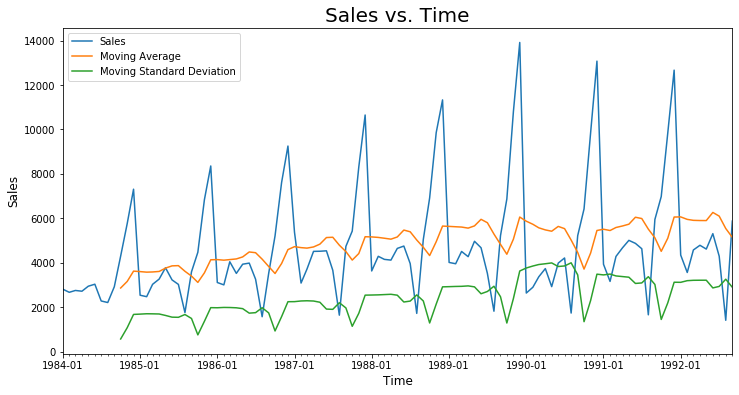

In [9]:
years = mdates.YearLocator()
months = mdates.MonthLocator() 
years_fmt = mdates.DateFormatter('%Y-%m')

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(sales.index, sales.Sales, label='Sales');

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

ax.set_xlim(sales.index[0], sales.index[-1])

ax.plot(sales.index, sales.rolling(10).mean(), label='Moving Average')
ax.plot(sales.index, sales.rolling(10).std(), label='Moving Standard Deviation')

ax.set_ylabel('Sales', fontsize=12)
ax.set_xlabel('Time', fontsize=12)
ax.set_title('Sales vs. Time', fontsize=20)
plt.legend(loc='upper left')
plt.show()

As can be seen from the plot above, there is periodicity (seasonality) in this data. During Christmas period, the sales reach highest values (Every December). 

There is also an increasing trend first but it seems like that after 1990, the increase stops. This can be observed from the moving average of the sales. 

Trend and seasonality is observed in the figure below as well. 

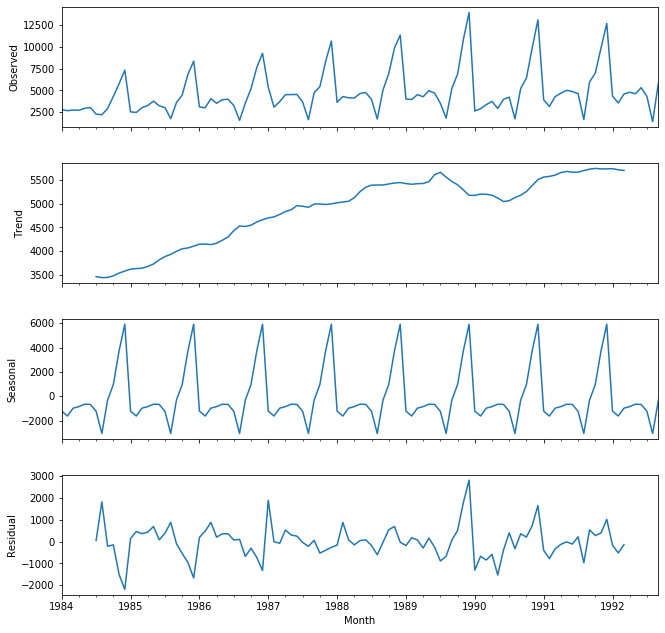

In [10]:
decomposition = sm.tsa.seasonal_decompose(sales, model='additive')
fig = decomposition.plot()
fig.set_size_inches(10, 10)
plt.show()

In [11]:
target = np.array(sales.Sales)
target

array([ 2815,  2672,  2755,  2721,  2946,  3036,  2282,  2212,  2922,
        4301,  5764,  7312,  2541,  2475,  3031,  3266,  3776,  3230,
        3028,  1759,  3595,  4474,  6838,  8357,  3113,  3006,  4047,
        3523,  3937,  3986,  3260,  1573,  3528,  5211,  7614,  9254,
        5375,  3088,  3718,  4514,  4520,  4539,  3663,  1643,  4739,
        5428,  8314, 10651,  3633,  4292,  4154,  4121,  4647,  4753,
        3965,  1723,  5048,  6922,  9858, 11331,  4016,  3957,  4510,
        4276,  4968,  4677,  3523,  1821,  5222,  6872, 10803, 13916,
        2639,  2899,  3370,  3740,  2927,  3986,  4217,  1738,  5221,
        6424,  9842, 13076,  3934,  3162,  4286,  4676,  5010,  4874,
        4633,  1659,  5951,  6981,  9851, 12670,  4348,  3564,  4577,
        4788,  4618,  5312,  4298,  1413,  5877])

### Exponential Smoothing for Time Series Forecasting

In [12]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from warnings import catch_warnings
from warnings import filterwarnings

Holt Winter's method is used to include seasonality and trend. 

In [13]:
sales.to_period().iloc[-9:]

,Sales
Month,
1992-01,4348
1992-02,3564
1992-03,4577
1992-04,4788
1992-05,4618
1992-06,5312
1992-07,4298
1992-08,1413
1992-09,5877


In [14]:
train_target = target[:-9]
test_target = target[-9:]

In [15]:
errors = []
params = []
p = 12 # period
for t in ['add', 'mul']:
    for s in ['add', 'mul']:
        for b in [True, False]:         
            
            params.append((t,s,b))  
            
            with catch_warnings():
                filterwarnings("ignore")
                model = ExponentialSmoothing(train_target, trend=t, damped=True, seasonal=s, \
                                                 seasonal_periods=p).fit(optimized=True, use_boxcox=b)
                    
                predicted = np.round(model.predict(len(train_target),len(train_target)+8))
                
                errors.append(np.sqrt(mean_squared_error(test_target, predicted)))                 

In [16]:
errors

[390.2224436850802,
 309.4784142535451,
 326.25620470898497,
 283.75928766004,
 65287.26055756292,
 1136.2742235530607,
 394.37306083340826,
 275.5761641039047]

In [17]:
index = np.argmin(errors)
print('The parameters that result in the minimum root mean square error is', params[index])
print('The minimum mean squared error is {:.2f}'.format(errors[index]))

The parameters that result in the minimum root mean square error is ('mul', 'mul', False)
The minimum mean squared error is 275.58


In [18]:
with catch_warnings():
    filterwarnings("ignore")
    modelFinal = ExponentialSmoothing(train_target, trend=params[index][0], damped=True, seasonal=params[index][1] \
            , seasonal_periods=p).fit(optimized=True, use_boxcox=params[index][2])

In [19]:
predictions = np.round(modelFinal.predict(len(train_target),len(train_target)+8))

In [20]:
predictions

array([3984., 3622., 4379., 4618., 4757., 4916., 4465., 1926., 5766.])

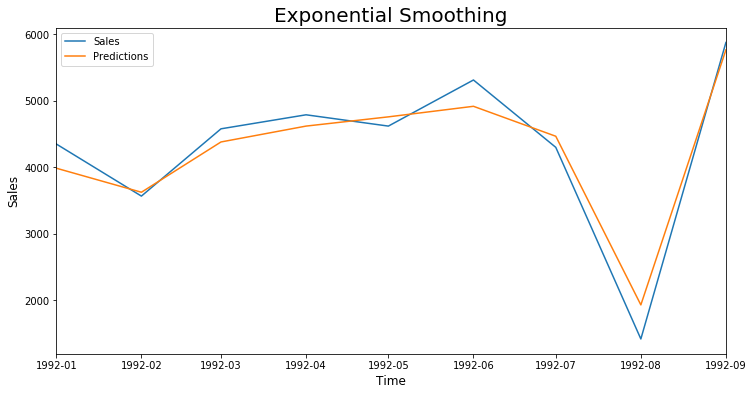

In [21]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(sales.index[-9:], sales.Sales[-9:], label='Sales');
ax.plot(sales.index[-9:], predictions, label='Predictions');

ax.set_xlim(sales.index[-9], sales.index[-1])

ax.set_ylabel('Sales', fontsize=12)
ax.set_xlabel('Time', fontsize=12)
ax.set_title('Exponential Smoothing', fontsize=20)
plt.legend(loc='upper left')
plt.show()

### SARIMA (Seasonal Autoregressive Integrated Moving Average) for Time Series Forecasting

Test if the time-series is stationary or not using Augmented Dickey Fuller Test. 

In [22]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(sales.Sales)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.833593
p-value: 0.363916


Since p-value is greater than 0.05, the time-series is non-stationary. This can be observed from the first plot as well by studying the moving average curve. 

In [23]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [24]:
params_SARIMA = []
errors_SARIMA = []
for p in pdq:
    for s in seasonal_pdq:
        
        params_SARIMA.append((p,s))
        
        with catch_warnings():    
            filterwarnings("ignore")
            model = sm.tsa.statespace.SARIMAX(train_target, order=p, seasonal_order=s).fit()
            predicted_SARIMA = np.round(model.predict(len(train_target),len(train_target)+8))
            errors_SARIMA.append(np.sqrt(mean_squared_error(test_target, predicted_SARIMA)))                            

In [25]:
index_SARIMA = np.argmin(errors_SARIMA)
print('The parameters that result in the minimum root mean square error is', params_SARIMA[index_SARIMA])
print('The minimum mean squared error is {:.2f}'.format(errors_SARIMA[index_SARIMA]))

The parameters that result in the minimum root mean square error is ((1, 0, 1), (1, 0, 0, 12))
The minimum mean squared error is 310.46


In [26]:
with catch_warnings():
    filterwarnings("ignore")
    modelFinal_SARIMA = sm.tsa.statespace.SARIMAX(train_target, order=params_SARIMA[index_SARIMA][0], 
                                                  seasonal_order=params_SARIMA[index_SARIMA][1]).fit()

In [27]:
predictions_SARIMA = np.round(modelFinal_SARIMA.predict(len(train_target),len(train_target)+8))
predictions_SARIMA

array([4206., 3444., 4497., 4849., 5148., 4999., 4751., 1891., 5978.])

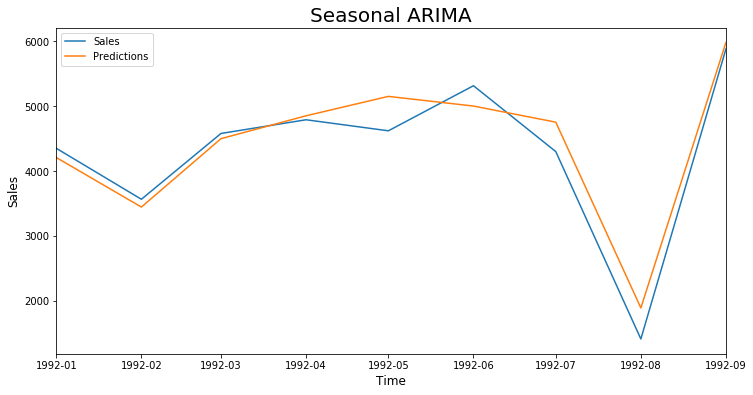

In [28]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(sales.index[-9:], sales.Sales[-9:], label='Sales');
ax.plot(sales.index[-9:], predictions_SARIMA, label='Predictions');

ax.set_xlim(sales.index[-9], sales.index[-1])

ax.set_ylabel('Sales', fontsize=12)
ax.set_xlabel('Time', fontsize=12)
ax.set_title('Seasonal ARIMA', fontsize=20)
plt.legend(loc='upper left')
plt.show()

### Conclusion and Results

Exponential smoothing resulted in the best predictions in terms of RMSE measured on the last 9 months. Therefore predictions made using exponential smoothing are saved to a csv file as shown below.  

In [29]:
results = pd.DataFrame({'Month':sales.index[-9:].to_period(), 'Sales':predictions})

In [30]:
results

,Month,Sales
0,1992-01,3984.0
1,1992-02,3622.0
2,1992-03,4379.0
3,1992-04,4618.0
4,1992-05,4757.0
5,1992-06,4916.0
6,1992-07,4465.0
7,1992-08,1926.0
8,1992-09,5766.0


In [31]:
results.to_csv('Predictions_Cosku_Deniz_Ozkoc.csv', index=False)

The hyperparameters for both exponential smoothing and SARIMA are optimized using RMSE on the validation data (last 9 months) as a measure. All the models (Expnential Smoothing, SARIMA and RNN) (RNN is implemented in a seperate Jupyter Notebook) are compared based on RMSE for the last 9 months. 

Since the hyperparemeters are tuned and models are compared based on RMSE for the last 9 months, the reporting of error on this dataset will not generalize well. In order to report generalization error, a seperate dataset should be used for testing. However, the aim here is not to report the generalziation error but to find the best time-series forecasting model for this dataset. Therefore a seperate test set is not used for generalization error. 

Different time-series models can be studied and these models can tried to be further tuned in order to decrease the RMSE measured on the last 9 months. This is left as a future work. 